# Analysis of monthly return data

## Description

- Calculate mean return per Style

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

## Load Data

In [2]:
path = '../data/processed/EDY/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

(2173160, 3)

In [3]:
path = '../data/processed/EDY/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(148063, 8)

In [4]:
path = '../data/processed/EDY/holdings_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(148063, 2382968)

In [5]:
path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

## Merge Crsp_Obj_Cd onto returns data

### Merge does not take dates into account -> TODO

In [6]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged.shape

(27135863, 11)

In [7]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(25327235, 11)

In [8]:
returns_merged.sample()

,crsp_fundno,caldt,mret,port_no,fund_no,report_dt,index_fund_flag,et_flag,crsp_obj_cd,mutual_fund,sample
10852513,19149.0,2008-06-30,-0.075949,1026282.0,19149.0,2012-12-31,MF,MF,EDYB,Y,Y


#### Take only needed columns and reorder them

In [9]:
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','crsp_obj_cd']]

In [10]:
returns_merged.sample()

,caldt,fund_no,port_no,mret,crsp_obj_cd
25710316,2018-05-31,52172.0,1031017.0,0.008766,EDYB


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [11]:
obj_codes = returns_merged[['crsp_obj_cd']].drop_duplicates()
obj_codes = obj_codes['crsp_obj_cd'].values

In [12]:
returns_merged.sample(1)

,caldt,fund_no,port_no,mret,crsp_obj_cd
11186047,2011-03-31,19609.0,1023216.0,0.006896,EDYG


In [13]:
# Analysis of selected funds
returns_obj = returns_merged.groupby(['crsp_obj_cd','caldt'])['mret'].agg(['mean','count','std'])

In [14]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [15]:
returns_obj['cummean'] = returns_obj.groupby('crsp_obj_cd')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [16]:
returns_obj_n = returns_obj.pivot_table(
        values='std', 
        index=['caldt'], 
        columns='crsp_obj_cd')

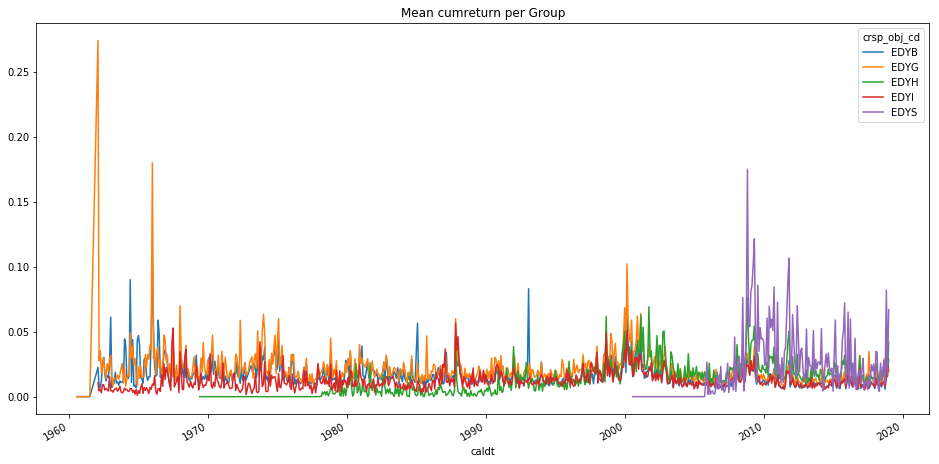

In [17]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [18]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AffinityPropagation

from sklearn.preprocessing import Normalizer, MaxAbsScaler

In [ ]:
Normalizer?

In [19]:
transformer = MaxAbsScaler().fit(holdings) # fit does nothing.
transformer

MaxAbsScaler(copy=True)

In [20]:
holdings = transformer.transform(holdings)

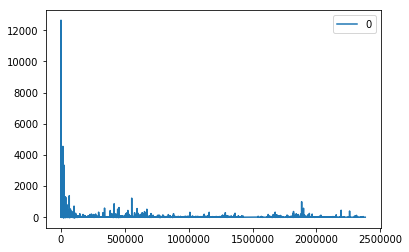

In [21]:
pd.DataFrame(holdings.sum(0)).T.plot()

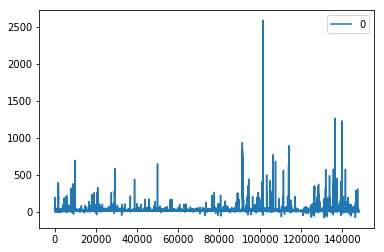

In [22]:
pd.DataFrame(holdings.sum(1)).plot()

In [ ]:
%%time
print('Start kMeans...')
kmeans = KMeans(n_clusters = 4,
                verbose = True,
                n_init = 5, # Number of runs
                n_jobs= -1,
                random_state=0).fit(holdings)

Start kMeans...
Initialization complete
Iteration  0, inertia 1291022.745
Iteration  1, inertia 1133315.193


In [ ]:
lables = pd.DataFrame(kmeans.labels_)

In [ ]:
summary['cluster'] = lables.values

In [ ]:
pd.crosstab(summary['crsp_obj_cd'],summary['cluster'])

## Chart the returns of the formed clustes

In [ ]:
summary.sample()

#### Merge new clusters onto returns

In [ ]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','crsp_obj_cd','cluster']]
returns_merged.sample()

#### Calc mean return per Obj_cd

In [ ]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

In [ ]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cummean'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [ ]:
returns_clus = returns_clus.pivot_table(
        values='std', 
        index=['caldt'], 
        columns='cluster')

In [ ]:
returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

# Samples per Fund -> weights per fund

In [103]:
index = pd.DataFrame(np.arange(summary.shape[0]))

In [104]:
index = index.groupby(summary['port_no']).tail(20)

In [105]:
index = index.values.T.flatten()

In [107]:
summary = summary.loc[index,:]
holdings = holdings[index]
holdings.shape

(64357, 2382968)

#### Sonstiges

In [67]:
result_mat = pd.DataFrame({'Clusters': clusters, 'Inertia':results})

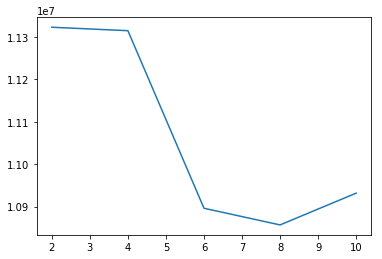

In [68]:
plt.plot(result_mat['Clusters'],result_mat['Inertia'])

# Visualize

In [71]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

ImportError: cannot import name 'DBSCAN' from 'sklearn.metrics' (/usr/local/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [30]:
MiniBatchKMeans?

For n_clusters = 4 The average silhouette_score is : -0.0004654317301733103


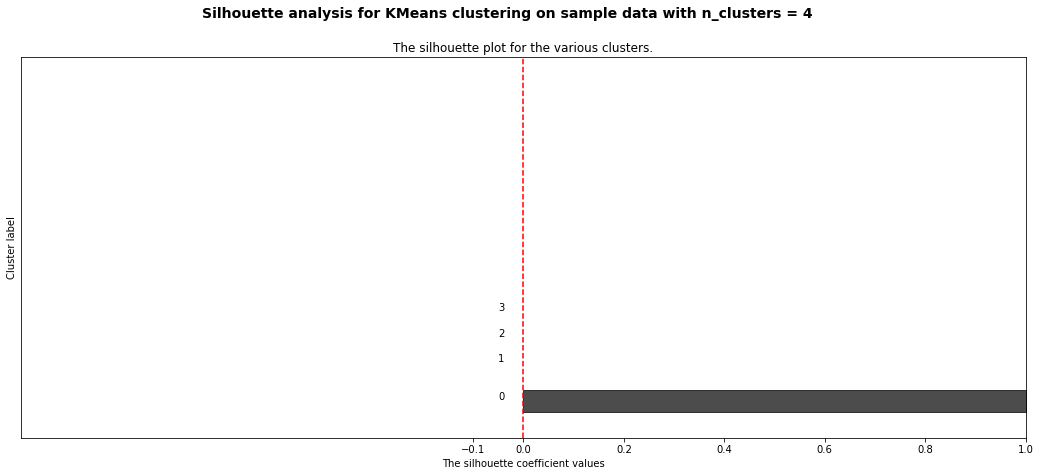

CPU times: user 597 ms, sys: 68.3 ms, total: 665 ms
Wall time: 326 ms


In [114]:
%%time
holdings = holdings[:3000]
X = holdings
n_clusters = [4]

clusters = []
results = []



for n_clusters in n_clusters:
    clusterer = DBSCAN(
                        eps=0.5, 
                        min_samples=5, 
                        metric='euclidean', 
                        metric_params=None, 
                        leaf_size=50, 
                        p=None, 
                        n_jobs=-1)
    
    
    cluster_fit = clusterer.fit(holdings)
#    clusters.append(n_clusters)
#    results.append(cluster_fit.inertia_)    
    
    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.15421306995166892
For n_clusters = 4 The average silhouette_score is : 0.4600189230961618
For n_clusters = 6 The average silhouette_score is : -0.12475102406298667
For n_clusters = 8 The average silhouette_score is : -0.15784371171105074
For n_clusters = 10 The average silhouette_score is : -0.28361917068289166


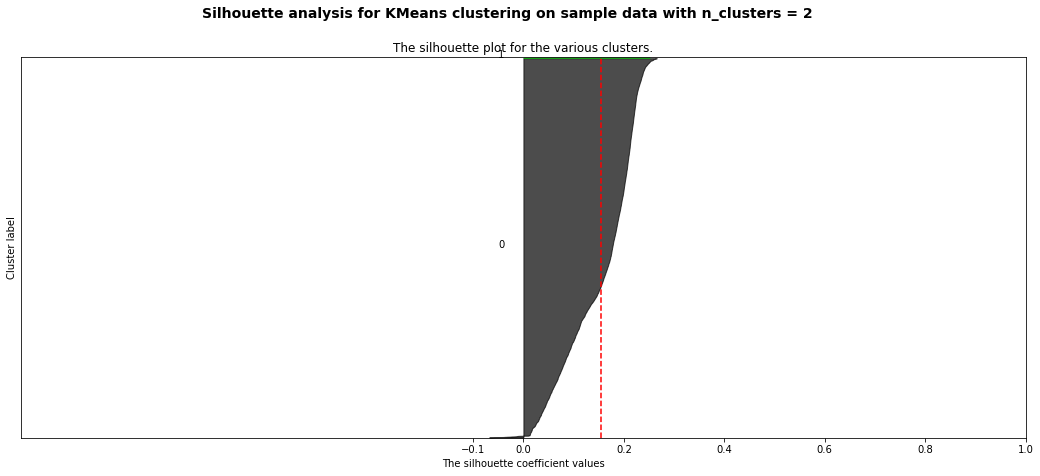

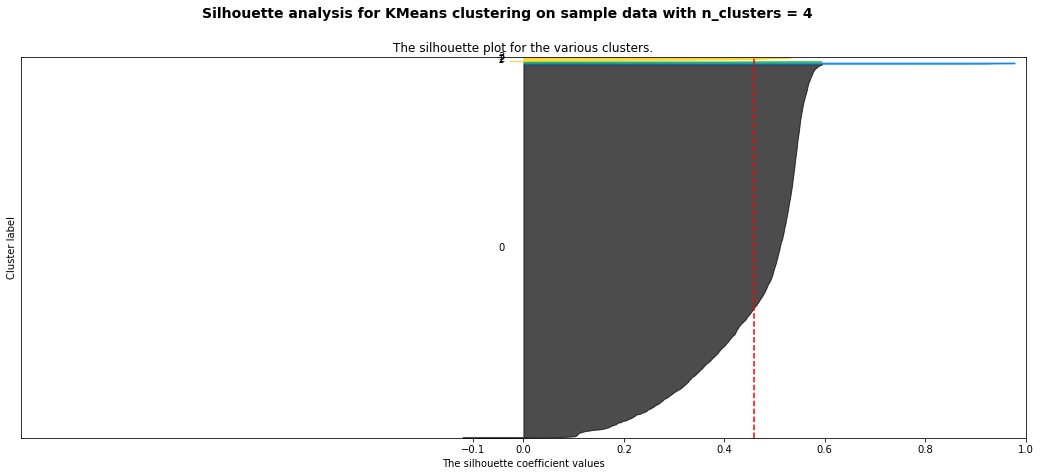

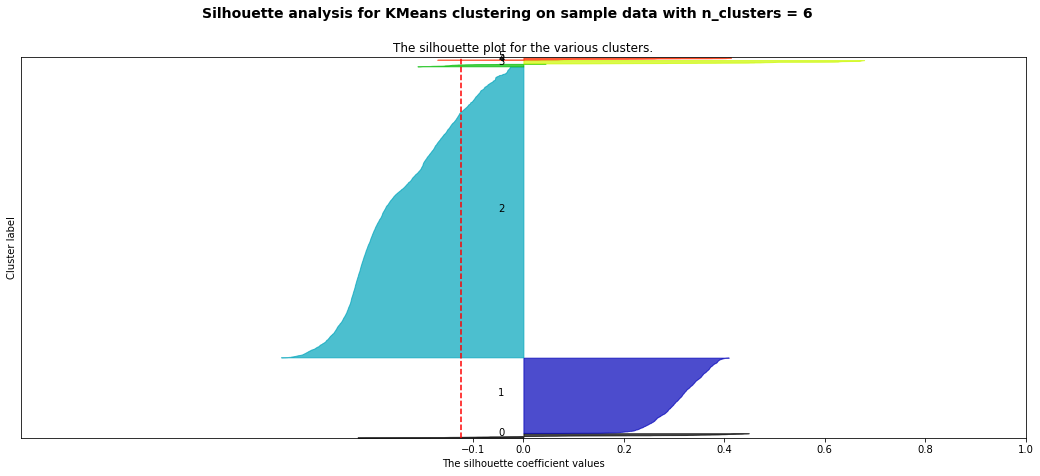

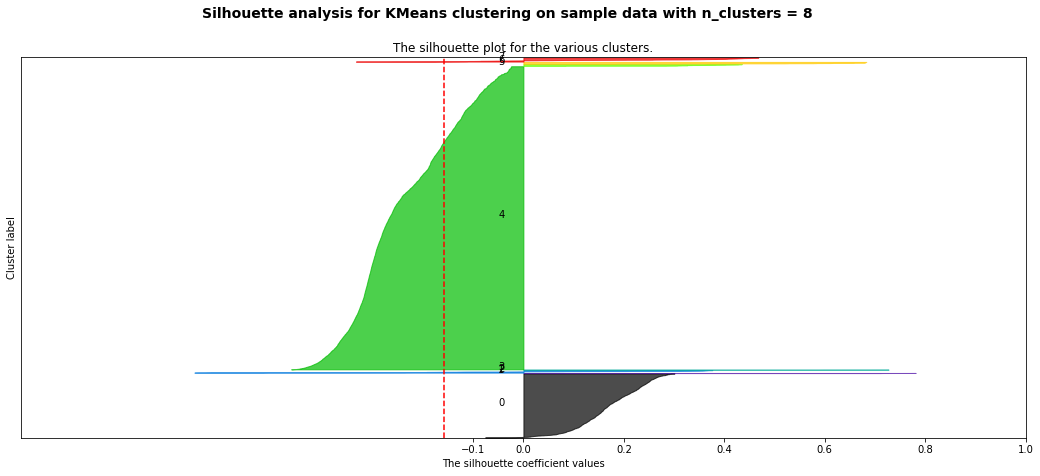

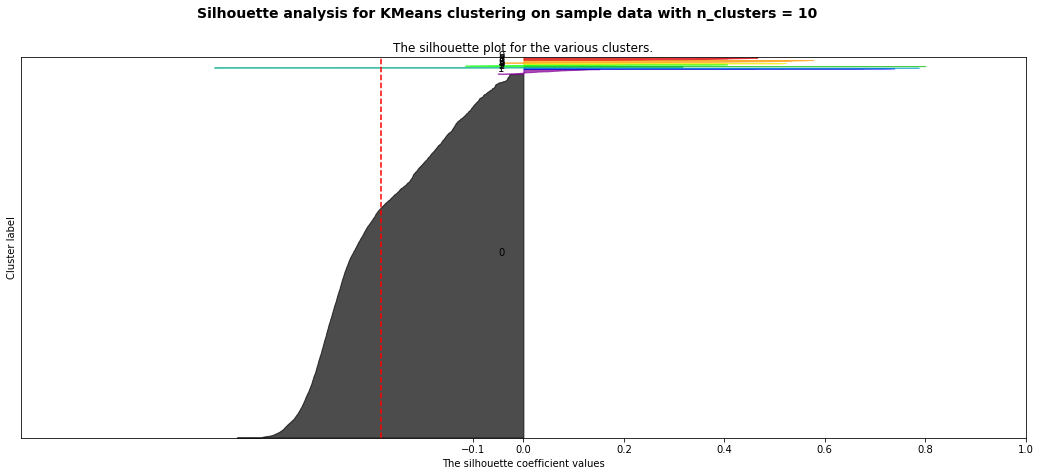

CPU times: user 1min 51s, sys: 28.4 s, total: 2min 19s
Wall time: 2min 17s


In [27]:
%%time
X = holdings
n_clusters = [2,4,6,8,10]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

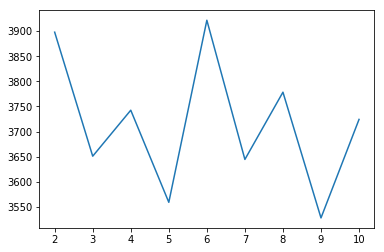

In [54]:
plt.plot(result_mat['Clusters'],result_mat['Inertia'])

In [ ]:
%%time
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

In [ ]:
## fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.2, 0.6])
ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

y_lower = 10
i = 0

for obj_code in obj_codes:

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == obj_code]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
        i =+ 1

plt.show()

In [ ]:
plt.close()